In [1]:
import sys
print sys.path

['', '/anaconda/lib/python27.zip', '/anaconda/lib/python2.7', '/anaconda/lib/python2.7/plat-darwin', '/anaconda/lib/python2.7/plat-mac', '/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/anaconda/lib/python2.7/lib-tk', '/anaconda/lib/python2.7/lib-old', '/anaconda/lib/python2.7/lib-dynload', '/anaconda/lib/python2.7/site-packages', '/anaconda/lib/python2.7/site-packages/Sphinx-1.5.6-py2.7.egg', '/anaconda/lib/python2.7/site-packages/aeosa', '/anaconda/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/vincentchen/.ipython']


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
vocab_matrix = np.load('./full_vocab_matrix.npy')

print 'vocab_matrix shape:', vocab_matrix.shape
num_examples = vocab_matrix.shape[1]

vocab_matrix shape: (10, 27924)


# Generate Primitives

In [3]:
class PrimitiveObject(object):

    def save_primitive_matrix(self,primitive_mtx):
        self.primitive_mtx = primitive_mtx
        self.discrete_primitive_mtx = primitive_mtx
        self.num_primitives = np.shape(self.primitive_mtx)[1]
    
    def save_primitive_names(self,names):
        self.primitive_names = names
        if len(self.primitive_names) != self.num_primitives:
            Exception('Incorrect number of Primitive Names')

In [4]:
def create_primitives(vocab_matrix):
    m = 5
    primitive_mtx = np.zeros((num_examples, m))
    for i in range(num_examples):
        primitive_mtx[i, 0] = vocab_matrix[0, :][i] # area
        primitive_mtx[i, 1] = vocab_matrix[1, :][i] # eccentricity
        primitive_mtx[i, 2] = vocab_matrix[6, :][i] # perimeter
        primitive_mtx[i, 3] = vocab_matrix[8, :][i] # intensity
    
    primitive_mtx[:, 4] = primitive_mtx[:, 0]/(primitive_mtx[:, 2]**2.) # ratio
    P = PrimitiveObject()
    P.save_primitive_matrix(primitive_mtx)
    return P

P = create_primitives(vocab_matrix)
primitive_names = ['area', 'eccentricity', 'perimeter', 'intensity', 'ratio']

# Heuristic Functions

In [5]:
def lf_area(area):
    if area >= 134:
        return -1 
    if area <= 65: 
        return 1
    return 0

def lf_eccentricity(eccentricity):
    if eccentricity >= 0.78: 
        return 1 
    if eccentricity <= 0.63:
        return -1  
    return 0
        
def lf_perimeter(perimeter):
    if perimeter <= 31: 
        return 1 
    return 0
    
def lf_intensity(intensity):
    if intensity >= 168: 
        return 1
    if intensity <= 108: 
        return -1
    return 0

def lf_ratio(ratio):
    if ratio >= 0.072: 
        return -1
    if ratio <= 0.062:
        return 1
    return 0

In [6]:
import sys
# sys.path.append('/dfs/scratch0/paroma/coral')
sys.path.append('../') #adding Coral Home, temp hack
sys.path.append('/Users/vincentchen/code/numbskull') # for numbskull
sys.path.append('/Users/vincentchen/code/coral-experimental/venv/lib/python2.7') # for numba
# sys.path.append('/afs/cs.stanford.edu/u/paroma/coral') #adding Coral Home, temp hack

L_names = [lf_area, lf_eccentricity, lf_perimeter, lf_intensity, lf_ratio]
from coral.static_analysis.dependency_learning import find_dependencies
L_deps = find_dependencies(L_names, primitive_names)
print L_deps

['', '/anaconda/lib/python27.zip', '/anaconda/lib/python2.7', '/anaconda/lib/python2.7/plat-darwin', '/anaconda/lib/python2.7/plat-mac', '/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/anaconda/lib/python2.7/lib-tk', '/anaconda/lib/python2.7/lib-old', '/anaconda/lib/python2.7/lib-dynload', '/anaconda/lib/python2.7/site-packages', '/anaconda/lib/python2.7/site-packages/Sphinx-1.5.6-py2.7.egg', '/anaconda/lib/python2.7/site-packages/aeosa', '/anaconda/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/vincentchen/.ipython', '../', '/Users/vincentchen/code/numbskull', '/Users/vincentchen/code/coral-experimental/venv/lib/python2.7', '/Users/vincentchen/code/coral', '/Users/vincentchen/code/numbskull', '/Users/vincentchen/code/coral-experimental/venv/lib/python2.7']


ImportError: No module named learning

In [43]:
L = np.zeros((len(L_names), num_examples))
for i in xrange(num_examples):
    for j in xrange(5):
        vocab_elems = P.primitive_mtx[i,L_deps[j]]
        L[j,i] = L_names[j](*vocab_elems)

## Evaluate HFs

In [37]:
# indexes for values that have HFs could not label
unlabeled = np.sum(np.abs(L), axis=0)
print len(unlabeled)
print 'Coverage:', 1-float(np.sum(unlabeled == 0))/len(unlabeled)

672
Coverage: 0.860119047619


In [10]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

total = float(num_examples)

stats_table = np.zeros((5,6))
# for i in range(5):   
for i in range(5):    
    predicted = L[i, :]
    stats_table[i,5] = precision_score(predicted[predicted != 0], labels[predicted != 0])
    stats_table[i,4] = recall_score(predicted[predicted != 0], labels[predicted != 0])
    stats_table[i,3] = f1_score(predicted[predicted != 0], labels[predicted != 0])
    stats_table[i,2] = np.sum(L[i,:] == labels)/float(np.sum(L[i,:] != 0))
    try: 
        stats_table[i,1] = roc_auc_score(predicted[predicted != 0], labels[predicted != 0])
    except ValueError as err: 
        stats_table[i,1] = None
        print 'LF:', i, err.args
    stats_table[i,0] = np.sum(L[i,:] != 0)/total


LF: 2 ('Only one class present in y_true. ROC AUC score is not defined in that case.',)


In [11]:
import pandas as pd
stats_table = pd.DataFrame(stats_table, index = [i.__name__ for i in L_names], columns = ["Coverage", "AUC", "Accuracy", "F1", "Recall", "Precision"])
stats_table

,Coverage,AUC,Accuracy,F1,Recall,Precision
lf_area,0.232143,0.607143,0.506410,0.393701,0.250000,0.925926
lf_eccentricity,0.714286,0.587273,0.643750,0.324111,0.200000,0.854167
lf_perimeter,0.169643,NaN,0.175439,0.298507,0.175439,1.000000
lf_intensity,0.119048,0.637931,0.475000,0.432432,0.275862,1.000000
lf_ratio,0.633929,0.597269,0.629108,0.352459,0.220513,0.877551


### Evaluate Majority Vote

In [12]:
def label_metrics(pred_labels, labels, description=''):
    print 'Accuracy of Coral on Train Set:', np.mean(labels == pred_labels)
    print 'Recall of Coral on Train Set:', recall_score(labels, pred_labels)
    print 'Precision of Coral on Train Set:', precision_score(labels, pred_labels)
    print 'F1 of Coral on Train Set:', f1_score(labels, pred_labels)

In [13]:
mv_labels = np.sign(np.sum(L.T,1))

label_metrics(mv_labels[mv_labels != 0], labels[mv_labels != 0])
print 'AUC of Coral on Train Set:', roc_auc_score(labels[mv_labels != 0], mv_labels[mv_labels != 0])

Accuracy of Coral on Train Set: 0.588454376164
Recall of Coral on Train Set: 0.923076923077
Precision of Coral on Train Set: 0.217391304348
F1 of Coral on Train Set: 0.351906158358
AUC of Coral on Train Set: 0.732724902216


## Run Coral Model

In [14]:
from coral.learning import CoralModel
from coral.learning import CoralDependencySelector
from numbskull.udf import *

from coral.static_analysis.dependency_learning import discretize_primitives

from scipy import sparse
L_train = sparse.csr_matrix(L.T)

### Discretize Primitives for Gibbs Sampler

In [15]:
code = discretize_primitives(L_names)
P.discrete_primitive_mtx = np.zeros((num_examples,len(primitive_names)))
for i in range(num_examples):
    for j in range(len(code)):
        exec(code[j])

P.discrete_primitive_mtx = P.discrete_primitive_mtx.astype(int)
cardinality = []
for v_idx in xrange(P.num_primitives):
    cardinality.append(int(np.max(P.discrete_primitive_mtx[:,v_idx])+1))

### Learn Accuracies and Assign Labels

#### Define helpers

In [16]:
def find_best_marginal_threshold(marginals, search_step=0.001):
    thresholds = np.arange(0, 1, search_step)
    plot_recall = np.zeros(thresholds.shape)
    plot_precision = np.zeros(thresholds.shape)
    plot_f1 = np.zeros(thresholds.shape)
    plot_accuracy = np.zeros(thresholds.shape)

    best_f1 = -1
    best_thresh = -1

    for i in range(len(thresholds)): 
        coral_labels = 2 * (marginals > thresholds[i]) - 1
        plot_recall[i] = recall_score(labels[unlabeled != 0], coral_labels[unlabeled != 0])
        plot_precision[i] = precision_score(labels[unlabeled != 0], coral_labels[unlabeled != 0])
        plot_f1[i] = f1_score(labels[unlabeled != 0], coral_labels[unlabeled != 0])
        plot_accuracy[i] = np.mean(labels[unlabeled != 0] == coral_labels[unlabeled != 0])


        if plot_f1[i] > best_f1: 
            best_f1 = plot_f1[i]
            best_thresh = thresholds[i]

    print 'best f1:', best_f1, 'best thresh:', best_thresh
    plt.plot(thresholds, plot_recall, label='recall')
    plt.plot(thresholds, plot_precision, label='precision')
    plt.plot(thresholds, plot_f1, label='f1')
    plt.plot(thresholds, plot_accuracy, label='accuracy')

    plt.axvline(x=best_thresh, color='black', label='chosen threshold')

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.grid()
    plt.show()
    
    return best_thresh

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

def auc_curves(marginals):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels[unlabeled != 0], mv_labels[unlabeled != 0], pos_label=1, drop_intermediate=False)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    false_positive_rate_coral, true_positive_rate_coral, thresholds_coral = roc_curve(labels[unlabeled != 0], marginals[unlabeled != 0], pos_label=1, drop_intermediate=False)
    roc_auc_coral = auc(false_positive_rate_coral, true_positive_rate_coral)

    print 'mv auc:', roc_auc, 'coral auc:', roc_auc_coral
    
    plt.title('ROC Curves for MV and Generative Models')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='MV Model')
    plt.plot(false_positive_rate_coral, true_positive_rate_coral, 'g',
    label='Generative Model')
    plt.plot([0,1],[0,1],'r--', label='Chance')
    plt.xlim([0,1.0])
    plt.ylim([0,1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [18]:
coral_model = CoralModel()

#### search for epoch hyperparameters. uncomment to run

In [19]:
# %%time

# from math import trunc

# best_train_epoch = None
# best_marginal_epoch = None
# best_auc = -1

# train_epochs = list(np.linspace(10, 1000, 5))
# marginals_epochs = list(np.linspace(10, 1000, 5))

# for t in train_epochs: 
#     for m in marginals_epochs: 
#         t_epochs = trunc(t)
#         m_epochs = trunc(m)
#         coral_model.train(P.discrete_primitive_mtx, cardinality, L_deps, MRI_UDF_OFFSET, 
#                           epochs=t_epochs)
#         marginals = coral_model.marginals(P.discrete_primitive_mtx, cardinality, L_deps, MRI_UDF_OFFSET, 
#                           epochs=m_epochs)


#         curr_auc = roc_auc_score(labels[unlabeled != 0], marginals[unlabeled != 0])
#         print 'train:', t_epochs, 'marginals:', m_epochs, 'auc:', curr_auc

#         if curr_auc > best_auc: 
#             best_auc = curr_auc
#             print 'new best auc'
#             best_train_epoch = t_epochs
#             best_marginal_epoch = m_epochs

# print "-----best-----"
# print 'train:', best_train_epoch, 'marginals:',best_marginal_epoch, 'auc:', best_auc


In [20]:
# best 505, 257
coral_model.train(P.discrete_primitive_mtx, cardinality, L_deps, MRI_UDF_OFFSET, epochs = 505)
marginals = coral_model.marginals(P.discrete_primitive_mtx, cardinality, L_deps, MRI_UDF_OFFSET, epochs=257)

best f1: 0.360856269113 best thresh: 0.456


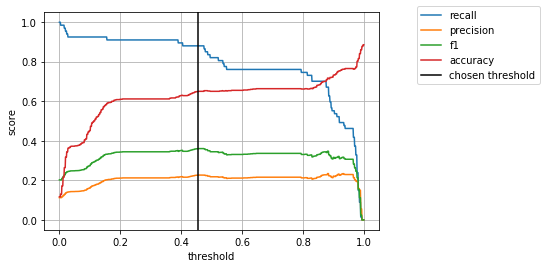

Accuracy of Coral on Train Set: 0.663879598662
Recall of Coral on Train Set: 0.746268656716
Precision of Coral on Train Set: 0.213675213675
F1 of Coral on Train Set: 0.332225913621


In [21]:
marginal_thresh = find_best_marginal_threshold(marginals, 0.001)
marginal_thresh = 0.81
coral_labels = 2 * (marginals > marginal_thresh) - 1
label_metrics(coral_labels[unlabeled != 0], labels[unlabeled != 0])

mv auc: 0.747421086657 coral auc: 0.737667594232


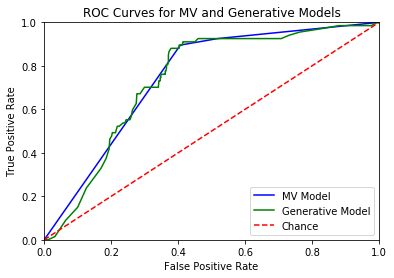

In [22]:
auc_curves(marginals)

In [23]:
print len(np.where(coral_labels == 1)[0])

234


### Assign Primitive Dependencies

#### hp tuning for `thresh`, `reg`, `t_epochs` and `m_epochs`. uncomment to run

In [24]:
# #Extra hyperparameters to search over to find primitive level dependencies

# best_thresh = None
# best_reg = None
# best_t_epochs = None
# best_m_epochs = None
# best_auc = -1

# # train_epochs = list(np.linspace(10, 1000, 5))
# # marginals_epochs = list(np.linspace(10, 1000, 5))
# train_epochs = [100]
# marginals_epochs = [1000]
# reg_candidates = list(np.logspace(-4, 1, 5))
# thresh_candidates = list(np.linspace(0.01, 0.2, 5))

# for thresh in thresh_candidates:
#     ds = CoralDependencySelector()
#     deps = ds.select(P.discrete_primitive_mtx, cardinality, L_deps, "MRI", threshold=thresh)
#     for reg in reg_candidates: 
#         for t in train_epochs: 
#             for m in marginals_epochs: 
#                 t_epochs = trunc(t)
#                 m_epochs = trunc(m)
        
#                 coral_model = CoralModel()
#                 coral_model.train(P.discrete_primitive_mtx, cardinality, L_deps, MRI_UDF_OFFSET, deps=list(deps), epochs=t_epochs, burn_in=0, reg_type=1, reg_param=reg)
#                 marginals_deps = coral_model.marginals(P.discrete_primitive_mtx, cardinality, L_deps, MRI_UDF_OFFSET, deps=list(deps), epochs=m_epochs)

#                 curr_auc = roc_auc_score(labels[unlabeled != 0], marginals_deps[unlabeled != 0])
#                 print 'auc:', curr_auc, 'thresh:', thresh, 'reg:', reg, 't_epochs:', t_epochs, 'm_epochs:', m_epochs

#                 if curr_auc > best_auc: 
#                     best_auc = curr_auc
#                     print 'new best auc'
#                     best_reg = reg
#                     best_thresh = thresh
#                     best_t_epochs = t_epochs
#                     best_m_epochs = m_epochs
            
# print "-----best-----"
# print 'thresh:', best_thresh, 'reg:', best_reg ,'auc:', best_auc, 'best_m_epochs:', best_m_epochs, 'best_t_epochs:', best_t_epochs

In [25]:
ds = CoralDependencySelector()
deps = ds.select(P.discrete_primitive_mtx, cardinality, L_deps, "MRI", threshold=0.0733333333333)
coral_model = CoralModel()
#Same calls as before but with additional "deps" argument in train and marginals
coral_model.train(P.discrete_primitive_mtx, cardinality, L_deps, MRI_UDF_OFFSET, deps=list(deps), epochs=1000, burn_in=0, reg_type=1, reg_param=0.0599484250319)
marginals_deps = coral_model.marginals(P.discrete_primitive_mtx, cardinality, L_deps, MRI_UDF_OFFSET, deps=list(deps), epochs=890)

/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best f1: 0.368580060423 best thresh: 0.483


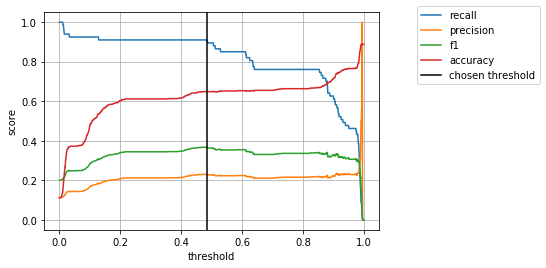

Accuracy of Coral on Train Set: 0.650501672241
Recall of Coral on Train Set: 0.910447761194
Precision of Coral on Train Set: 0.231060606061
F1 of Coral on Train Set: 0.368580060423


In [26]:
marginal_thresh = find_best_marginal_threshold(marginals_deps, 0.001)
coral_labels = 2 * (marginals_deps > marginal_thresh) - 1
label_metrics(coral_labels[unlabeled != 0], labels[unlabeled != 0])

In [27]:
# attempt to manually set threshold 
coral_labels = 2 * (marginals_deps > 0.95) - 1
label_metrics(coral_labels[unlabeled != 0], labels[unlabeled != 0])
print 1.0* np.sum(coral_labels[unlabeled != 0] == 1) / len(coral_labels[unlabeled != 0])

Accuracy of Coral on Train Set: 0.765886287625
Recall of Coral on Train Set: 0.462686567164
Precision of Coral on Train Set: 0.22962962963
F1 of Coral on Train Set: 0.306930693069
0.225752508361


mv auc: 0.747421086657 coral auc: 0.756359445709


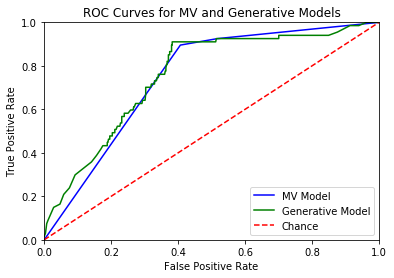

In [28]:
auc_curves(marginals_deps)

In [29]:
np.save('marginals.npy', marginals_deps)